# Соберем сверточную нейронную сеть LiNet5

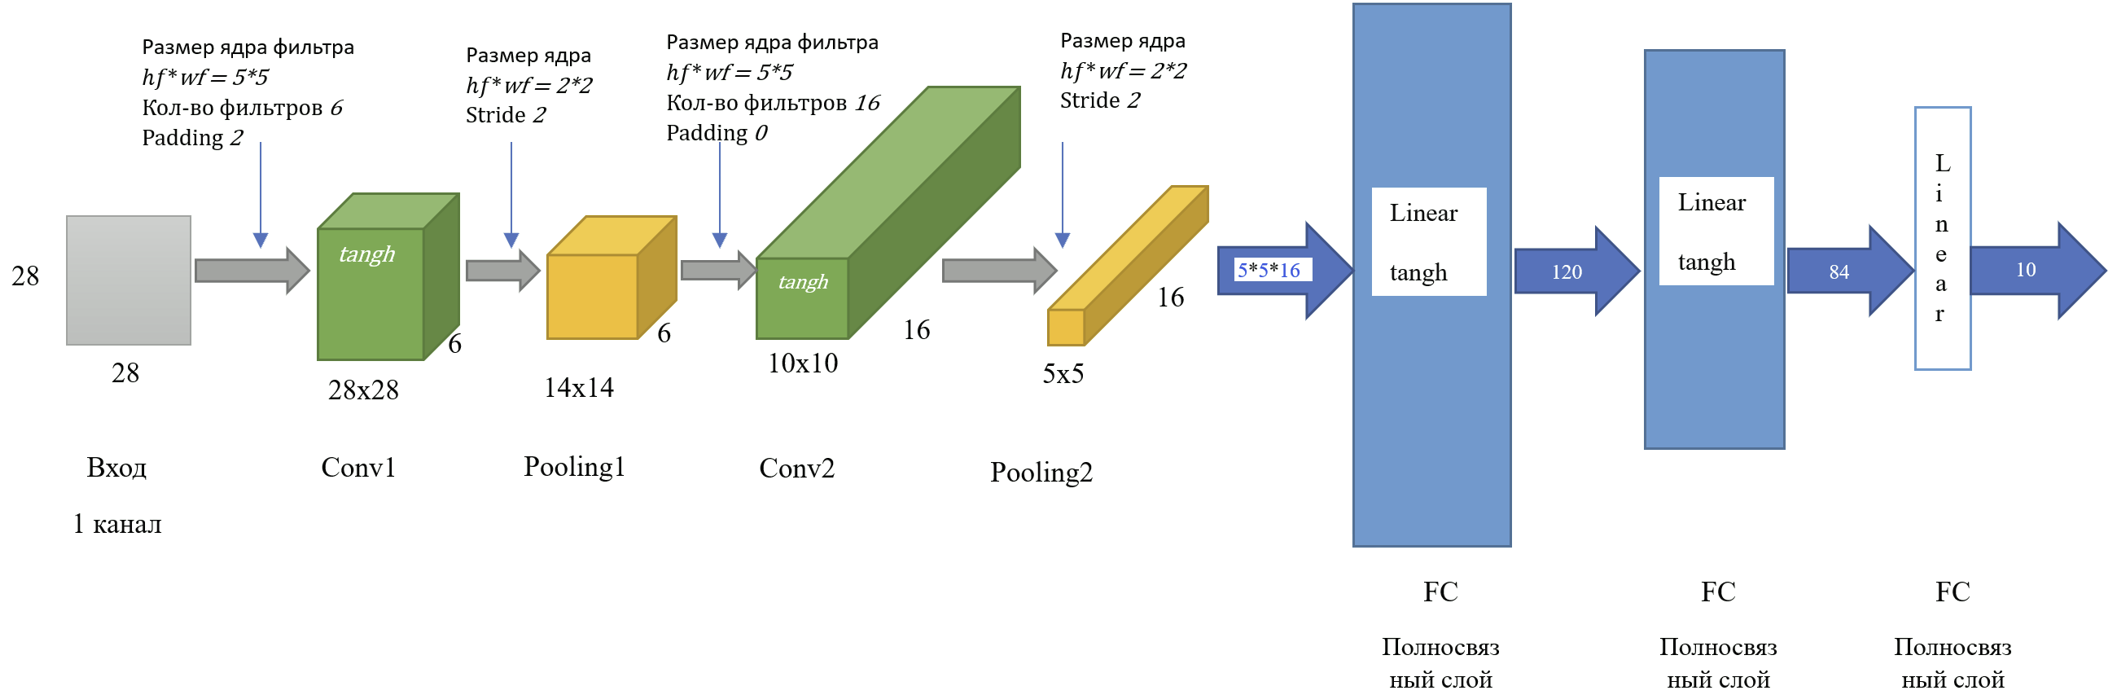


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет 28 × 28, функция активации tangh;
**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет 14 × 14, функция активации AvgPooling;
**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет 10 × 10, функция активации tangh;
**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет 5 × 5, функция активации AvgPooling;
**Слой FC** представляет собой полносвязанный слой, вход 5*5*16 нейронов (признаков), выход 120 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 120 нейронов (признаков), выход 84 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 84 нейронов (признаков), выход 49 нейронов;



#### Про датасет ####  
Kuzushiji-MNIST - это готовая замена набору данных MNIST (28x28 градаций серого, 70 000 изображений), представленная как в оригинальном формате MNIST, так и в формате NumPy. Поскольку MNIST ограничивает нас 10 классами, при создании Kuzushiji-MNIST мы выбрали по одному иероглифу для представления каждой из 10 строк хираганы.

Kuzushiji-49, как следует из названия, имеет 49 классов (28x28 градаций серого, 270 912 изображений), представляет собой гораздо больший, но несбалансированный набор данных, содержащий 48 символов хираганы и один знак итерации хираганы.

Для данной лабораторной работы будет использован датасет Kuzushiji-49.

Ссылка на датасет: https://github.com/rois-codh/kmnist?tab=readme-ov-file  
  
Изначально пытался обучать модель по датасету Kuzushiji-49, но обработка эпох проходила очень долго потому пришлось сменить датасет.
  
Изменений в коде немного, так как итоговый датасет похож на оригинальный.

In [23]:
!pip install dill

In [24]:
# импортируем библиотеки
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [102]:
# Данный код предлагается автором датасета для его загрузки
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:09<00:00, 1868.88KB/s]


100%|██████████| 30/30 [00:00<00:00, 363.10KB/s]


100%|██████████| 3008/3008 [00:02<00:00, 1200.24KB/s]


100%|██████████| 6/6 [00:00<00:00, 10690.66KB/s]

All dataset files downloaded!


In [68]:
X_train = torch.from_numpy(np.load('kmnist-train-imgs.npz')['arr_0'])
y_train = torch.from_numpy(np.load('kmnist-train-labels.npz')['arr_0'])
X_test = torch.from_numpy(np.load('kmnist-test-imgs.npz')['arr_0'])
y_test = torch.from_numpy(np.load('kmnist-test-labels.npz')['arr_0'])

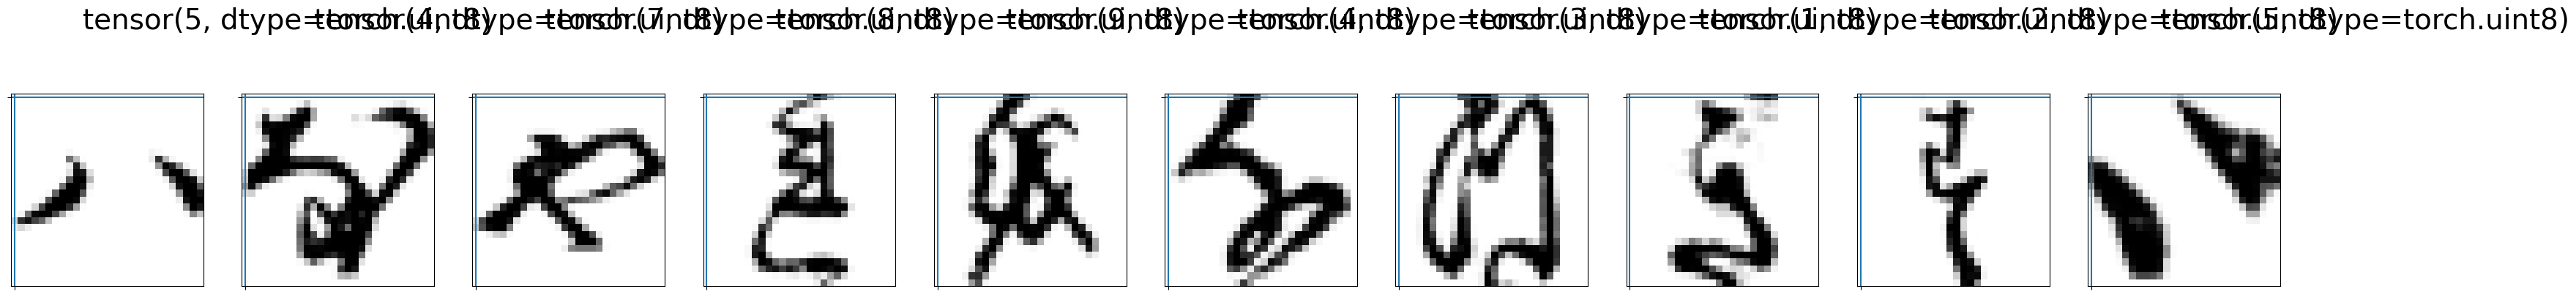

In [69]:
# посмотрим, что пришло

import numpy as np
import matplotlib.pyplot as plt

# посмотрим какие-то произвольные изображения из датасета
count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=28)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [70]:
# сколько изображений в трейне и тесте
print('Размер трейна: ', len(y_train), '\nРазмер теста: ', len(y_test))

Размер трейна:  60000 
Размер теста:  10000


In [71]:
import matplotlib.pyplot as plt

X_train_copy_for_show = X_train
y_train_copy_for_show = y_train

#Функция для отрисовки иероглифа
def showImg(im_number):
  # вот как хранятся изображения в компьютере
  print(f"image:\n{X_train_copy_for_show[im_number, :, :]}")

  # а так их видим мы
  plt.imshow(X_train_copy_for_show[im_number, :, :])

  plt.show()
  print(y_train_copy_for_show[im_number])

image:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           9, 109, 142, 116,  91,  79,  21,   1,   0,   0,   0,   0,   0,   0],
        [  0,   3,  41,   8,   0,   0, 

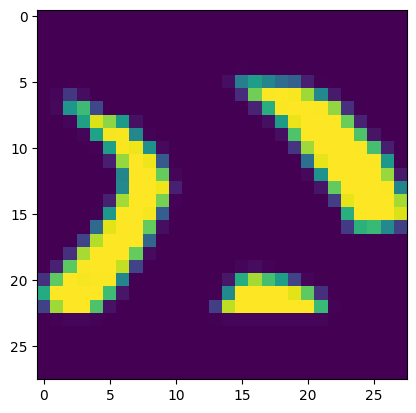

tensor(5, dtype=torch.uint8)


In [72]:
# нарисуем, c чем мы имеем дело
showImg(10)

In [73]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [74]:
X_train.shape

torch.Size([60000, 28, 28])

In [75]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([60000, 28, 28])  ---- станет torch.Size([60000, 1, 28, 28])
# и все значения - во float

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [76]:
# сколько изображений в трейне и тесте
print('Shape Х трейна: ', X_train.shape, '\nShape X теста: ', X_test.shape)

Shape Х трейна:  torch.Size([60000, 1, 28, 28]) 
Shape X теста:  torch.Size([10000, 1, 28, 28])


In [77]:
# Определяем класс, которые и будет представлять нашу нейронку
# какие слои - см описание вначале блокнота

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU() #С данной функцией активации модель показала лучшие результаты
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU() #С данной функцией активации модель показала лучшие результаты
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU() #С данной функцией активации модель показала лучшие результаты

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU() #С данной функцией активации модель показала лучшие результаты

        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [78]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

# ЕСЛИ ВЫ ОБУЧИТЕ НЕЙРОНКУ НА GPU или CPU ОНА ДЛЯ СВОЕЙ РАБОТЫ БУДЕТ ТРЕБОВАТЬ ИЛИ GPU, ИЛИ CPU
Поэтому не всегда возможно использование обучения на GPU просто потому, что сервер или компьютер пользователя не будет поддерживать расчеты на GPU

In [79]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [80]:
# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

In [82]:
#Эпохи
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

for epoch in range(50): #Изменил количество эпох так как обработка даже 50 заняла по итогу минут 20-30
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.9350000023841858 
epoch1 - accuracy test 0.9451000094413757 
epoch2 - accuracy test 0.9413999915122986 
epoch3 - accuracy test 0.9434000253677368 
epoch4 - accuracy test 0.9373999834060669 
epoch5 - accuracy test 0.9448999762535095 
epoch6 - accuracy test 0.9447000026702881 
epoch7 - accuracy test 0.9484000205993652 
epoch8 - accuracy test 0.9544000029563904 
epoch9 - accuracy test 0.9470000267028809 
epoch10 - accuracy test 0.9477999806404114 
epoch11 - accuracy test 0.9431999921798706 
epoch12 - accuracy test 0.9491000175476074 
epoch13 - accuracy test 0.9485999941825867 
epoch14 - accuracy test 0.942799985408783 
epoch15 - accuracy test 0.9470999836921692 
epoch16 - accuracy test 0.9466999769210815 
epoch17 - accuracy test 0.9520000219345093 
epoch18 - accuracy test 0.9477999806404114 
epoch19 - accuracy test 0.9460999965667725 
epoch20 - accuracy test 0.9487000107765198 
epoch21 - accuracy test 0.9433000087738037 
epoch22 - accuracy test 0.9463000297546387 

<ipython-input-83-fd538a322c0e>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


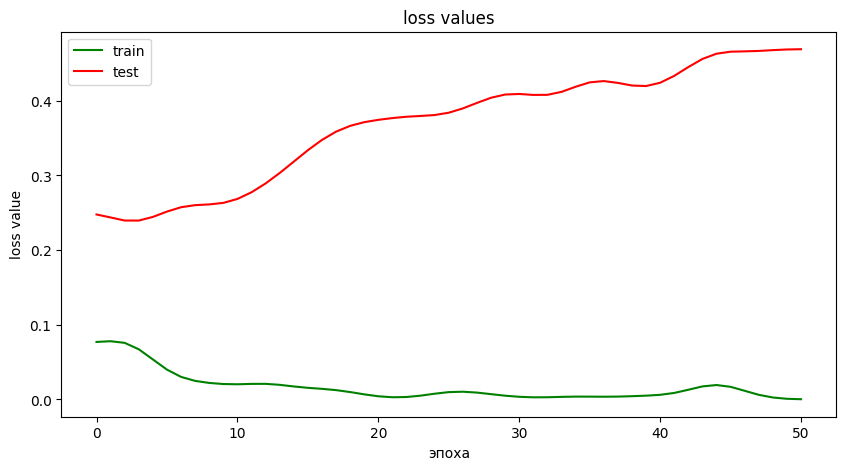

In [83]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



<ipython-input-84-7ea75e20b699>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


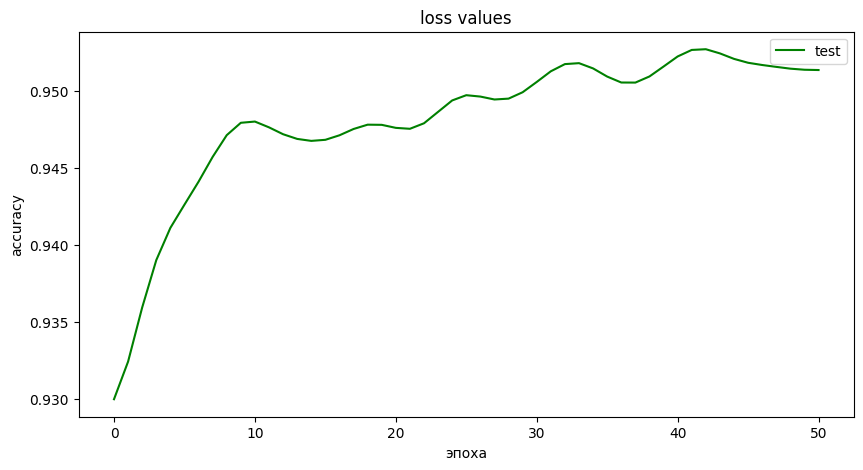

In [84]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [85]:
imgNumber = 1

In [86]:
# Сохраняем произвольное изображение из датасета (тензор) в файл
timg = X_train[imgNumber]
torch.save(timg,'tensor.pt')


In [87]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([1, 28, 28])

In [88]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()

# то есть нам нужен тензор размера [1,1,28,28]

torch.Size([10000, 1, 28, 28])

In [89]:
# вот так сохраняют модель с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [90]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(lenet5, pickle_file)

In [91]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
#from LeNET_5 import LeNet
import pandas as pd
import numpy as np



ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


<ipython-input-91-58d101a88a51>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [92]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

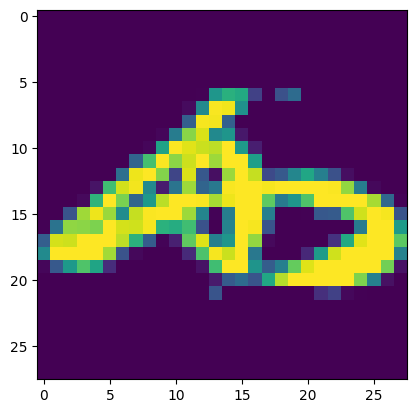

In [93]:
# смотрим, что за цифру считали
plt.imshow(test_data[0, :, :])
plt.show()

In [94]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

<ipython-input-94-94f1da74720b>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  t_data = torch.tensor([test_data.numpy()])


In [95]:
# проверяем
t_data.shape

torch.Size([1, 1, 28, 28])

In [96]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [97]:
# делаем предсказание
preds = modelp.forward(t_data)

In [98]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[ -8.9274, -36.2938, -38.9621, -20.5720, -28.8698, -23.7110, -15.2712,
          53.5060,  -9.1260, -28.7068]], grad_fn=<AddmmBackward0>)


In [99]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)[0]

In [100]:
# смотрим, что предсказалось
print('Результат: ', prediction)

Результат:  7


image:
tensor([[  0,   0,   0,   0,   0,   0,   0,  69, 166, 218, 252, 212,  75,  11,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  16, 106, 206, 247, 246, 126,  21,   0,   0,
           0,   0,   0,   0,  32,   9,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   3,  94, 252, 233, 212, 102,   1,   2,  47,   0,
           0,   0,   1, 108, 210,  82,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   6, 184, 218,  46,   3,   0,   0,  91, 129,   0,
           0,   0,  60, 247, 250,  30,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   1, 113, 244, 230,  73,   0,   4, 194, 158,   0,
           0,   0, 121, 255, 223,   3,   0,   0,   0,  26,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  11, 218, 255, 220,  27,  49, 247, 194,   1,
           0,   0, 163, 255, 218,   0,   0,   0,   0,   1,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  47, 

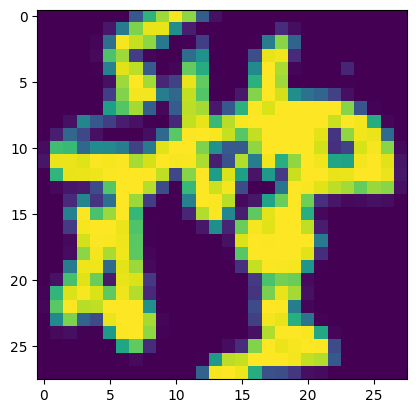

tensor(8, dtype=torch.uint8)


In [101]:
showImg(prediction)